In [46]:
import pandas as pd

df = pd.read_csv('Suicide_Detection.csv')
df.drop("Unnamed: 0",axis=1,inplace=True)
df

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...
232069,If you don't like rock then your not going to ...,non-suicide
232070,You how you can tell i have so many friends an...,non-suicide
232071,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,The usual stuff you find hereI'm not posting t...,suicide


In [47]:
def bin_suicide(val): #1 = suicide, 0 = non-suicide 
    if val == "suicide":
        return 1
    else:
        return 0
df["class"]=list(map(bin_suicide,df["class"]))
df.describe()

,class
count,232074.000000
mean,0.500000
std,0.500001
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [48]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from tqdm.notebook import tqdm
from joblib import Parallel, delayed, parallel_backend
from tqdm_joblib import tqdm_joblib

import nltk
packages = ['stopwords','punkt_tab','wordnet','vader_lexicon']

# Download only if not already present
for package in packages:
    try:
        nltk.data.find(f"tokenizers/{package}")  # Check if package exists
    except LookupError:
        nltk.download(package, quiet=True)  # Download if not found

stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove links
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return ' '.join(words)

def parallel_process(df, func, num_jobs=-1):
    with tqdm_joblib(tqdm(desc="Processing", total=len(df), unit="row")):
        with parallel_backend("loky"):
            results = Parallel(n_jobs=num_jobs)(
                delayed(func)(text) for text in df["text"]
            )
    return results

from nltk.corpus import wordnet

df["text"] = parallel_process(df, preprocess_text)
df.head()

Processing:   0%|          | 0/232074 [00:00<?, ?row/s]

  0%|          | 0/232074 [00:00<?, ?it/s]

,text,class
0,ex wife threatening suiciderecently left wife ...,1
1,weird get affected compliment coming someone k...,0
2,finally 2020 almost never hear 2020 bad year e...,0
3,need helpjust help im cry hard,1
4,losthello name adam 16 struggling year afraid ...,1


In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

vectorizer = TfidfVectorizer(max_features=5000)  # Extract top 5000 words
X = vectorizer.fit_transform(df["text"]).toarray()
y = df["class"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X.shape

(232074, 5000)

In [50]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [51]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.9005709361197889
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.86      0.90     23139
           1       0.87      0.94      0.90     23276

    accuracy                           0.90     46415
   macro avg       0.90      0.90      0.90     46415
weighted avg       0.90      0.90      0.90     46415

Confusion Matrix:
 [[19838  3301]
 [ 1314 21962]]


In [52]:
def predict(text):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text]).toarray()
    return classifier.predict(vectorized_text)[0]

In [135]:
from collections import Counter
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Genreate cluster map for top words using seaborn
def generate_cluster_map(input_df,source_column,top_word_count = 30):
    input_df["clean_text"] = input_df[source_column].astype(str).apply(lambda x: x.split())
    
    # Flatten the list of words and count frequency
    all_words = [word for sublist in input_df["clean_text"] for word in sublist]
    word_counts = Counter(all_words)
    
    # Select top N words
    top_words = word_counts.most_common(top_word_count)
    word_list = [word for word, _ in top_words]
    
    # Create a co-occurrence matrix
    word_indices = {word: idx for idx, word in enumerate(word_list)}
    co_occurrence_matrix = np.zeros((top_word_count, top_word_count))
    
    # Build word relationships (co-occurrences within a window)
    window_size = 5
    for words in input_df["clean_text"]:
        for i, word in enumerate(words):
            if word in word_indices:
                for j in range(1, window_size):
                    if i + j < len(words) and words[i + j] in word_indices:
                        co_occurrence_matrix[word_indices[word], word_indices[words[i + j]]] += 1
                        co_occurrence_matrix[word_indices[words[i + j]], word_indices[word]] += 1
    
    # Plot the heatmap
    plt.figure(figsize=(12, 10))
    sns.clustermap(co_occurrence_matrix, 
                   xticklabels=word_list, 
                   yticklabels=word_list, 
                   cmap="coolwarm", 
                   figsize=(12, 10), 
                   method="ward")  # You can change the clustering method if needed
    
    plt.title("Word Co-occurrence Cluster Map")
    plt.show()


<Figure size 1200x1000 with 0 Axes>

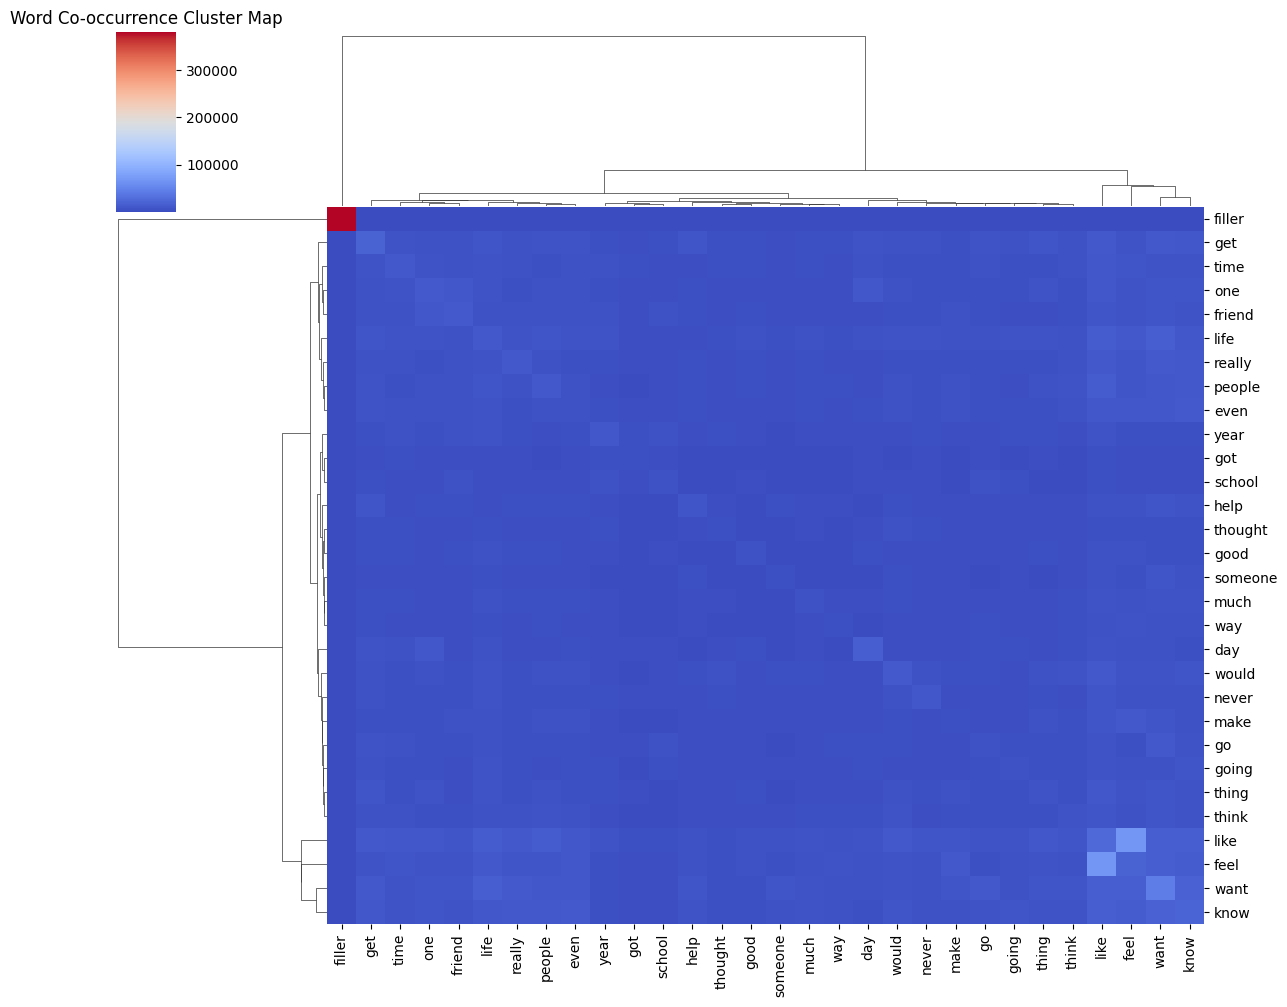

In [136]:
# Clustering for most frequent words in training dataset
generate_cluster_map(df,"text")

In [72]:
#testing
import pandas as pd
import datetime

df_test = pd.read_csv("mental_disorders_reddit.csv")

# Truncating test data because of computation cap, adjust according to available resource
test_data_size = 10000
df_test = df_test[:min(test_data_size , len(df_test))]

In [73]:
df_test.dropna(inplace=True)
df_test = df_test[~df_test['selftext'].isin(['[removed]', '[null]'])] #removes null
#reformats created_utc
df_test['created_utc'] = pd.to_numeric(df_test['created_utc'], errors='coerce')
df_test['created_utc'] = pd.to_datetime(df_test['created_utc'], unit='s')
df_test['created_utc'] = df_test['created_utc'].dt.strftime('%Y-%m-%d %H:%M:%S')

df_test.drop('over_18',axis=1,inplace=True)
df_test.reset_index(drop=True, inplace=True)
#change dtypes
df_test['title']=df_test['title'].astype('category')
df_test['selftext']=df_test['selftext'].astype('category')
df_test['subreddit']=df_test['subreddit'].astype('category')

tqdm.pandas()

df_test['class'] = df_test["selftext"].progress_apply(predict)

  0%|          | 0/6161 [00:00<?, ?it/s]

In [139]:
df_test

,title,selftext,created_utc,subreddit,class,clean_text
0,Life is so pointless without others,Does anyone else think the most important part...,2022-04-19 08:29:20,BPD,0,"[Does, anyone, else, think, the, most, importa..."
1,Cold rage?,Hello fellow friends 😄\n\nI'm on the BPD spect...,2022-04-19 08:24:20,BPD,1,"[Hello, fellow, friends, 😄, I'm, on, the, BPD,..."
2,I don’t know who I am,My [F20] bf [M20] told me today (after I said ...,2022-04-19 08:02:59,BPD,0,"[My, [F20], bf, [M20], told, me, today, (after..."
3,HELP! Opinions! Advice!,"Okay, I’m about to open up about many things I...",2022-04-19 07:30:30,BPD,1,"[Okay,, I’m, about, to, open, up, about, many,..."
4,My ex got diagnosed with BPD,"Without going into detail, this diagnosis expl...",2022-04-19 06:43:55,BPD,1,"[Without, going, into, detail,, this, diagnosi..."
...,...,...,...,...,...,...
6156,DAE occasionally have episodes that last for w...,Diagnosed BPD but it doesn't seem to explain s...,2022-10-17 13:25:43,BPD,1,"[Diagnosed, BPD, but, it, doesn't, seem, to, e..."
6157,My partner of 2 years ghosted me and I'm broken,How on earth do I navigate this? \n\n\nLiteral...,2022-10-17 13:24:55,BPD,1,"[How, on, earth, do, I, navigate, this?, Liter..."
6158,Please share with me your experiences of shame.,"Hi all,\n\nI am going through therapy (DBT and...",2022-10-17 13:22:30,BPD,1,"[Hi, all,, I, am, going, through, therapy, (DB..."
6159,Diagnosis?,Ive been told that i cannot claim i have bpd w...,2022-10-17 13:21:13,BPD,1,"[Ive, been, told, that, i, cannot, claim, i, h..."


In [75]:
# First, convert 'subreddit' to string
df_test['subreddit'] = df_test['subreddit'].astype(str)

# Then group by 'subreddit' and aggregate only numeric columns
numeric_cols = df_test.select_dtypes(include=['number']).columns
mean_values = df_test.groupby('subreddit')[numeric_cols].mean()
std_values = df_test.groupby('subreddit')[numeric_cols].std()

print(mean_values)
print(std_values)

              class
subreddit          
BPD        0.900828
              class
subreddit          
BPD        0.298917


In [76]:
df_test.describe()

,class
count,6161.000000
mean,0.900828
std,0.298917
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

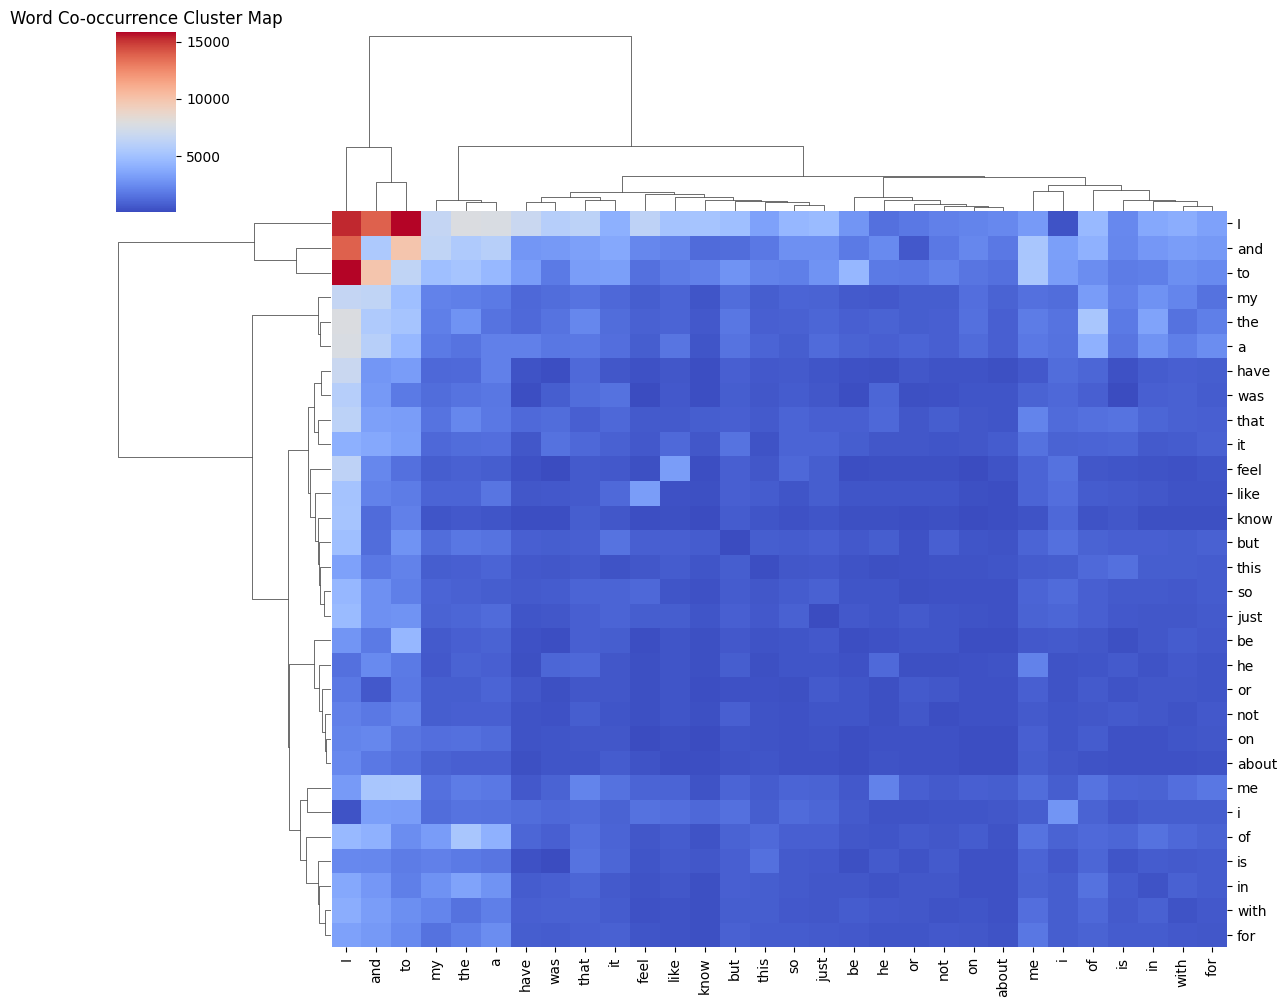

In [130]:
# Clustering for most frequent words in test dataset
generate_cluster_map(df_test,'selftext')

In [128]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def generate_cluster_negetive_words(input_df, source_column, top_word_count=30):
    input_df["clean_text"] = input_df[source_column].astype(str).apply(lambda x: x.split())
    
    # Create dictionary of negativity scores for all words
    all_words = [word for sublist in input_df["clean_text"] for word in sublist]
    word_negativity = {word: sia.polarity_scores(word)["neg"] for word in set(all_words)}
    # Step 2: Compute word frequency
    word_freq = Counter(all_words)
    # Sort words by negativity (descending)
    sorted_words = sorted(word_freq.keys(), key=lambda w: (word_negativity[w], word_freq[w]), reverse=True)
    # Select top N most negative words
    word_list = sorted_words[:top_word_count]
    
    word_indices = {word: idx for idx, word in enumerate(word_list)}
    co_occurrence_matrix = np.zeros((top_word_count, top_word_count))
    
    window_size = 5  # Define context window
    for words in input_df["clean_text"]:
        # if isinstance(words, list):
        for i, word in enumerate(words):
            if word in word_indices:
                for j in range(1, window_size):
                    if i + j < len(words) and words[i + j] in word_indices:
                        co_occurrence_matrix[word_indices[word], word_indices[words[i + j]]] += 1
                        co_occurrence_matrix[word_indices[words[i + j]], word_indices[word]] += 1
    
    sns.clustermap(co_occurrence_matrix, 
                   xticklabels=word_list, 
                   yticklabels=word_list, 
                   cmap="coolwarm", 
                   figsize=(12, 10), 
                   method="ward")  # Hierarchical clustering
    
    plt.title("Word Co-occurrence Cluster Map (Top Negative Words)")
    plt.show()

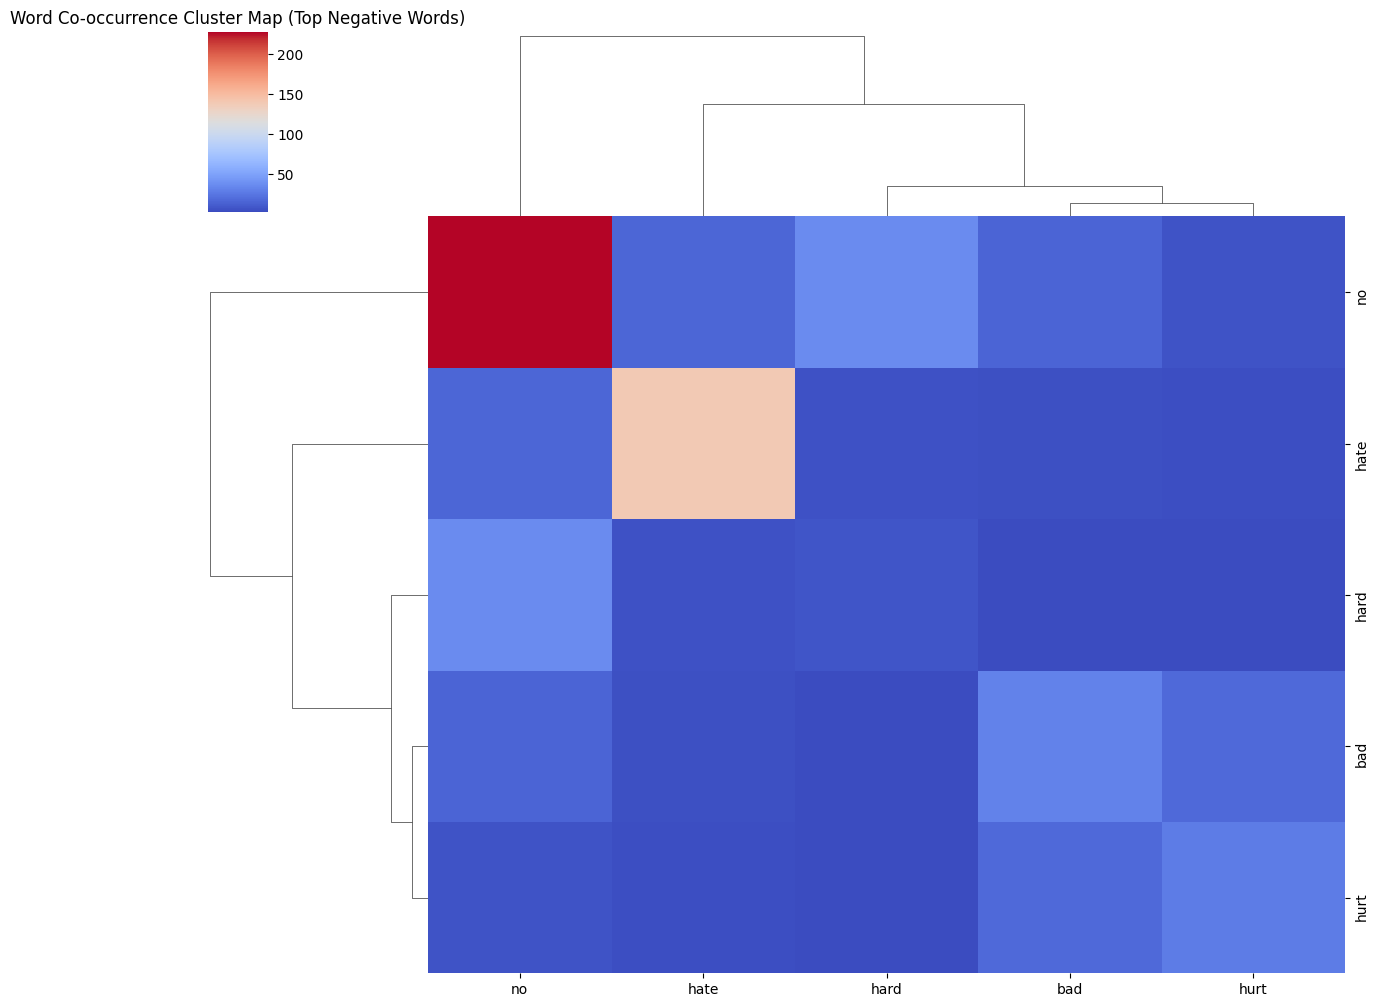

In [133]:
# Clustering for most negetive and frequent words in test dataset
generate_cluster_negetive_words(df_test,'selftext',5)

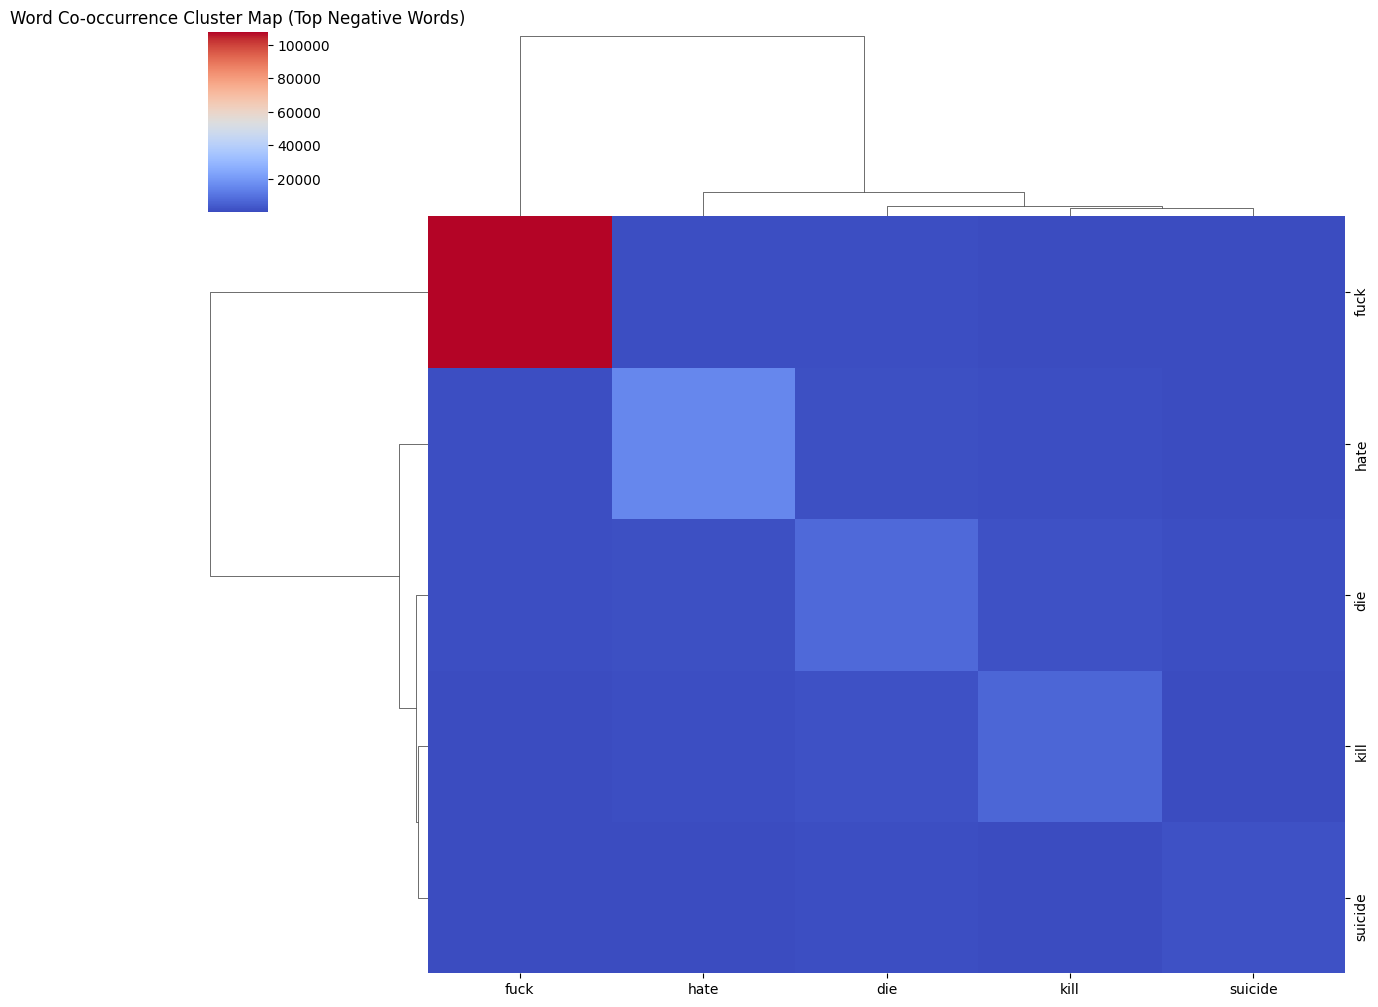

In [134]:
# Clustering for most negetive and frequent words in training dataset
generate_cluster_negetive_words(df,'text',5)

('bpd', 'fp', 'feel', 'help', 'just', 'like', 'advice', 'don', 'relationship', 'need', 'people', 'know', 'does', 'feeling', 'want', 'think', 'partner', 'love', 'stop', 'person')


/var/folders/8k/jnx7rdj94lg_5gp1c26zw5rh0000gq/T/ipykernel_92442/1471587349.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(frequencies), y=list(topics), palette="coolwarm")


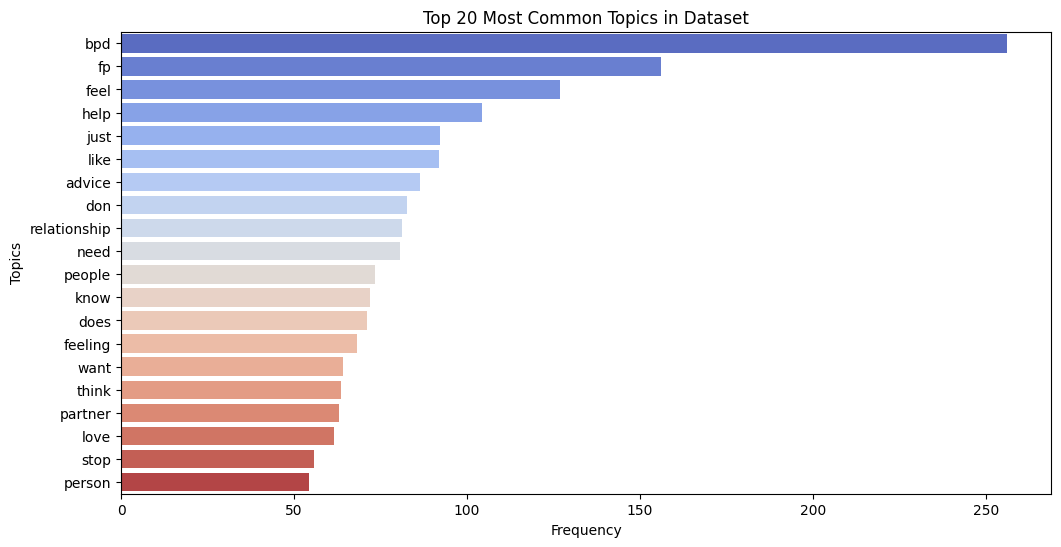

In [154]:
X = vectorizer.fit_transform(df_test["title"])

# Compute word frequency from TF-IDF
tfidf_scores = X.sum(axis=0).A1  # Sum TF-IDF scores across all documents
feature_names = vectorizer.get_feature_names_out()

word_counts = Counter(dict(zip(feature_names, tfidf_scores)))
sorted_topics = word_counts.most_common(20)  # Get top 20 topics

# Extract words and their frequencies
topics, frequencies = zip(*sorted_topics)

print(topics) 


# Plot bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=list(frequencies), y=list(topics), palette="coolwarm")

plt.xlabel("Frequency")
plt.ylabel("Topics")
plt.title("Top 20 Most Common Topics in Dataset")
plt.show()